In [3]:
import sys 
from tqdm import tqdm
sys.path.append('..');
from model import *



/home/luzhenyu/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'filelock'

In [6]:
import clip
import torch
import torchvision
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()

import torch
import pandas as pd
import whisper
import torchaudio
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
whisper_model = whisper.load_model("base.en").eval()
options = whisper.DecodingOptions(language="en", without_timestamps=True)
print()

/home/luzhenyu/.local/lib/python3.8/site-packages/whisper/__init__.py:63: UserWarning: /home/luzhenyu/.cache/whisper/base.en.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(
100%|███████████████████████████████████████| 139M/139M [00:41<00:00, 3.51MiB/s]


In [16]:
# can avoid running this if results are cached
from util.util import wav_to_text, text_to_embed, img_to_embed


import matplotlib.pyplot as plt
import numpy as np
image_feat_list = []
text_feat_list = []
whisper_text_feat_list = []
ids_seen = set()
whisper_texts = []
true_texts = []
img_to_text_idx = defaultdict(lambda : [])
text_to_img_idx = defaultdict(lambda : [])
id_to_img_idx = dict()

coco_samples_to_eval = 1000


for idx, sample in tqdm(enumerate(locnarr_dataset)): #could also tqdm over dev_set
    text = sample['text']
    img = sample['image']
    wav = sample['wav']
    whisper_text = wav_to_text(wav, whisper_model, options)
    text_features = text_to_embed(text, model)
    whisper_text_features = text_to_embed(whisper_text, model)
    image_features = img_to_embed(img, model, preprocess)
    
    
    text_feat_list  += [text_features[0].tolist()]
    whisper_text_feat_list += [whisper_text_features[0].tolist()]
    whisper_texts += [whisper_text]
    true_texts += [text]
    
    if sample['id'] not in ids_seen:
        image_feat_list += image_features.tolist()
        id_to_img_idx[sample['id']] = len(image_feat_list)-1
        ids_seen.add(sample['id'])
    
    cur_image_idx = id_to_img_idx[sample['id']]
    cur_text_idx = len(true_texts)-1
    
    img_to_text_idx[cur_text_idx] += [cur_image_idx]
    text_to_img_idx[cur_image_idx] += [cur_text_idx]
    if idx == coco_samples_to_eval-1:
        break
    
    
results = (image_feat_list, text_feat_list, whisper_text_feat_list, whisper_texts, true_texts,
          dict(img_to_text_idx), dict(text_to_img_idx), id_to_img_idx)
with open('locnarr_whisper_results_cache.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/media/exx/HDD/zhenyulu/data/coco/locnarr/coco_val/coco_val_322944_38.ogg_eod49pi.tmp'

In [8]:
with open('locnarr_whisper_results_cache.pkl', 'rb') as handle:
    results = pickle.load(handle)
image_feat_list, text_feat_list, whisper_text_feat_list, whisper_texts, true_texts,\
          img_to_text_idx, text_to_img_idx, id_to_img_idx = results

In [9]:
from torchmetrics.functional import word_error_rate
whisper_lower = [text.lower() for text in whisper_texts]
true_lower = [text.lower() for text in true_texts]
WERs = [float(word_error_rate(whisper_lower[i], true_lower[i])) for i in range(len(whisper_lower))]
overall_WER = word_error_rate(whisper_lower, true_lower)

In [10]:
from sklearn.neighbors import KDTree
def get_recall(source_feat_list, target_feat_list, target_idx_to_source_idx_dict, recall_levels=[1, 5, 10]):
    # source_feat_list is the list of embeddings in the query modality
    # target_feat_list is the list of embeddings in the target modality
    # target_idx_to_source_idx_dict is a dictionary going from an index in target_feat_list to a list of indeces in source_feat_list
    # used to determine if a given target is correct for a given source
    tree = KDTree(target_feat_list)
    idxs = np.array(tree.query(source_feat_list, k=recall_levels[-1])[1])
    a = idxs[0]
    closest_ids = [[target_idx_to_source_idx_dict[id] for id in idx] for idx in idxs]
    recall_avgs = []
    recalls = []
    for recall_level in recall_levels: 
        recall_at_level = []
        for source_idx in range(len(source_feat_list)):
            recalls_list = closest_ids[source_idx] # list of lists
            recalls_list = recalls_list[0:recall_level] # shortened to only contain ones for current recall level
            recalls_list_flat = []
            for a in recalls_list:
                recalls_list_flat += a
            recall_at_level += [source_idx in recalls_list_flat]
        print(f'recall at level {recall_level}: {np.mean(recall_at_level)}')
        recall_avgs += [np.mean(recall_at_level)]
        recalls += [recall_at_level]
    return recalls, recall_avgs

print('CLIP base, locnarr:')
print('text to image recall')
a = get_recall(text_feat_list, image_feat_list, text_to_img_idx)
print('image to text recall')
a = get_recall(image_feat_list, text_feat_list, img_to_text_idx)

CLIP base, locnarr:
text to image recall
recall at level 1: 0.337
recall at level 5: 0.633
recall at level 10: 0.749
image to text recall
recall at level 1: 0.42286348501664817
recall at level 5: 0.7014428412874584
recall at level 10: 0.802441731409545


CLIP with Whisper, locnarr:
text to image recall
recall at level 1: 0.25
recall at level 5: 0.511
recall at level 10: 0.638
image to text recall
recall at level 1: 0.316315205327414
recall at level 5: 0.5749167591564928
recall at level 10: 0.6870144284128746


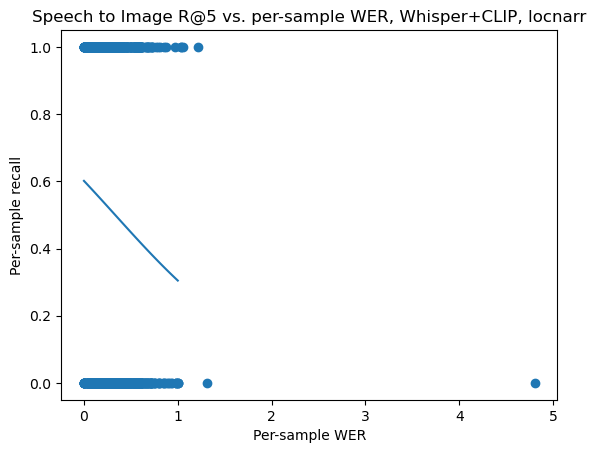

In [27]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

print('CLIP with Whisper, locnarr:')
print('text to image recall')
a = get_recall(whisper_text_feat_list, image_feat_list, text_to_img_idx)
recall_at_5 = a[0][1]
print('image to text recall')
a = get_recall(image_feat_list, whisper_text_feat_list, img_to_text_idx)

plt.scatter(WERs, recall_at_5)
x_new = np.linspace(0, 1, 50)
logreg_x = np.array(WERs)[:,np.newaxis]
logreg_y = np.array(recall_at_5).astype(int)
logreg = LogisticRegression()
logreg.fit(logreg_x, logreg_y)
y_new = logreg.predict_proba(x_new[:,None])
plt.plot(x_new, y_new[:,1])
plt.xlabel('Per-sample WER')
plt.ylabel('Per-sample recall')
plt.title('Speech to Image R@5 vs. per-sample WER, Whisper+CLIP, locnarr')
plt.show()

In [26]:
bad_idx = np.argsort(WERs)[-1]
print(whisper_lower[bad_idx])
true_lower[bad_idx]

here we can see every airplane. the turbine trans present and we can see group of people walking and standing with bags in their hand and they are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present and we are going to the bus present 

'here we can see a wing of aeroplane with the turbine fans present and we can see a group of people walking and standing with bags in their hand and they are going to the bus present in front of them'

In [ ]:
wav = dev_set[0]['wav']
audio = whisper.pad_or_trim(wav.flatten()).cuda()
mel = whisper.log_mel_spectrogram(audio)
results = model.decode(mel, options)
print(results.text)
print(dev_set[0]['text'])